**Problem 1: Imports were scattered, poorly organised, and there is no proper documentation**

- _Why_: The code has imports scattered throughout, making dependencies unclear and potentially causing import errors, also the code has very little documentation which makes it tough to understand.
- _Fix_: Consolidate imports at the top of the file and provided good explanation for each cell.


In [35]:
# All imports consolidated at the top
import pandas as pd
import numpy as np
import networkx as nx
import math
import sklearn.cluster
import sklearn.preprocessing
import matplotlib.pyplot as plt
import networkx.algorithms
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt


**Problem 2: Missing data validation and cleaning**

   - _Why_: The code assumes clean data without validating inputs
   - _Fix_: Add data validation and cleaning steps


In [36]:
# Load the both CSV files
df_directorships = pd.read_csv("company_directorships.csv")
df_details = pd.read_csv("director-details.csv")

# Validate data
print("Missing values in directorships:")
print(df_directorships.isnull().sum())
print("\nMissing values in details:")
print(df_details.isnull().sum())

# Remove duplicates and standardise names
df_directorships = df_directorships.drop_duplicates()
df_directorships['director_name'] = df_directorships['director_name'].str.upper().str.strip()

Missing values in directorships:
company_name           0
cikcode                0
director_name          0
software_background    0
start_date             0
end_date               0
dtype: int64

Missing values in details:
id                 0
url                0
name               0
age                0
role               1
compensation       0
source_excerpt     0
created_at         0
gender            21
dtype: int64


In [37]:
# Convert software_background to boolean and analyze distribution
df_directorships['software_background'] = df_directorships['software_background'].map({'t': True, 'f': False})

# Calculate the percentage of directors with a software background
software_percentage = df_directorships['software_background'].mean() * 100
print(f"Percentage of directors with software background: {software_percentage:.2f}%")

Percentage of directors with software background: 17.43%


**TASK 3 :Explore something in the existing dataset**

an interesting unexplored feature is the `start_date` and `end_date` columns in the company_directorships.csv file. This temporal data could provide valuable insights about:
1. Director tenure lengths
2. Board turnover rates
3. Temporal patterns in board appointments
4. Which directors have the longest-running board positions?
5. Whether companies tend to appoint new directors in specific time periods

This temporal dimension isn't currently being used in the network analysis but could reveal important patterns about board dynamics. Here's a quick analysis to demonstrate its potential:


In [38]:
# Convert dates to datetime
df_directorships['start_date'] = pd.to_datetime(df_directorships['start_date'])
df_directorships['end_date'] = pd.to_datetime(df_directorships['end_date'])

# Calculate tenure length in years
df_directorships['tenure'] = (df_directorships['end_date'] - df_directorships['start_date']).dt.days / 365.25

# Basic statistics about director tenures
print("Director Tenure Statistics (in years):")
print(df_directorships['tenure'].describe())

# Show directors with the longest tenures
print("\nTop 5 Longest-Serving Board Positions:")
print(df_directorships.nlargest(10, 'tenure')[['director_name', 'company_name', 'tenure']])

Director Tenure Statistics (in years):
count    13347.000000
mean         4.854090
std          4.849831
min          0.000000
25%          0.996578
50%          3.969884
75%          7.017112
max         24.046543
Name: tenure, dtype: float64

Top 5 Longest-Serving Board Positions:
               director_name                       company_name     tenure
4762     CLAUDETTE J.V. CHAN                         FONAR CORP  24.046543
7086    MARTIN L. DREIBELBIS      JUNIATA VALLEY FINANCIAL CORP  24.038330
12375      ANTOINE M. DOUMET  UNITED STATES LIME & MINERALS INC  24.002738
12385      RICHARD W. CARDIN  UNITED STATES LIME & MINERALS INC  24.002738
12388       TIMOTHY W. BYRNE  UNITED STATES LIME & MINERALS INC  24.002738
11834        ELLEN R. GORDON        TOOTSIE ROLL INDUSTRIES INC  23.997262
11835  LANA JANE LEWIS-BRENT        TOOTSIE ROLL INDUSTRIES INC  23.997262
10406       DAVID A. ADAMSEN                 SEABOARD CORP /DE/  23.994524
10407       DOUGLAS W. BAENA             

In [39]:
# Standardise director names to uppercase to prevent duplicate entries due to case differences
df_details['NAME'] = df_details.name.str.upper()

# Helper function to find the most frequent value in a series
# Returns None if the series is empty, otherwise returns the most common value
def most_common(series):
    """
    Determines the most common value in a given pandas Series. The function
    computes the mode of the series and returns the first mode value if present.
    If the series has no mode, it returns None.

    :param series: The pandas Series for which the most common value is to be
        determined.
    :type series: pandas.Series
    :return: The most common value in the series or `None` if there is no mode.
    :rtype: Any
    """
    mode_values = series.mode()
    if len(mode_values) > 0:
        return mode_values[0]
    return None

# Create aggregated demographics DataFrame by director name:
# - Age: take the maximum (most recent) age
# - Compensation: sum all compensation entries
# - Gender: take the most frequent value to handle inconsistencies
compensation_and_demographics = pd.DataFrame({
    'age': df_details.groupby('NAME').age.max(),
    'compensation': df_details.groupby('NAME').compensation.sum(),
    'gender': df_details.groupby('NAME').gender.agg(most_common)
})

# Apply log10 transformation to compensation (adding 1 to handle zero values)
# This helps normalise the typically skewed distribution of compensation data
compensation_and_demographics['log_compensation'] = (1 + compensation_and_demographics.compensation).map(math.log10)

# Display the resulting DataFrame with aggregated director information
compensation_and_demographics

,age,compensation,gender,log_compensation
NAME,,,,
A. CATHERINE NGO,64,1006154,female,6.002665
A. EUGENE WASHINGTON,70,324871,male,5.511712
A. F. PETROCELLI,80,47000,male,4.672107
A. FARAZ ABBASI,52,113631,male,5.055501
A. LARRY CHAPMAN,78,259500,male,5.414139
...,...,...,...,...
ZACKARY IRANI,58,360103,male,5.556428
ZAHID AFZAL,62,0,male,0.000000
ZENA SRIVATSA ARNOLD,46,189960,female,5.278664


In [40]:
# Analyse gender distribution among directors, including missing values (NaN)
# This helps assess:
# 1. Gender diversity in corporate leadership
# 2. Data completeness (NaN count)
# 3. Data quality (unexpected categories)

compensation_and_demographics.gender.value_counts(dropna=False)

gender
male       3850
female     1550
None         19
unknown       2
Name: count, dtype: int64

In [41]:
# Calculate the number of unique companies each director serves on
# 1. Group by director_name is to collect all records for each director
# 2. company_name.nunique() counts unique companies per director
# 3. sort_values() arranges the results in ascending order
directorship_counts = df_directorships.groupby('director_name').company_name.nunique().sort_values()

# Display the sorted series showing the number of directorships per person
directorship_counts

director_name
ÅSA HEDIN                 1
A. F. PETROCELLI          1
A. FARAZ ABBASI           1
A. J. SORDONI, III        1
A. J. STRICKLAND, III     1
                         ..
ROBERT C. TROCCOLI       13
RODNEY F. DAMMEYER       13
JOEL W. MOTLEY           13
TERESA M. RESSEL         13
ALBERT R. DOWDEN         14
Name: company_name, Length: 11827, dtype: int64

<Axes: xlabel='company_name'>

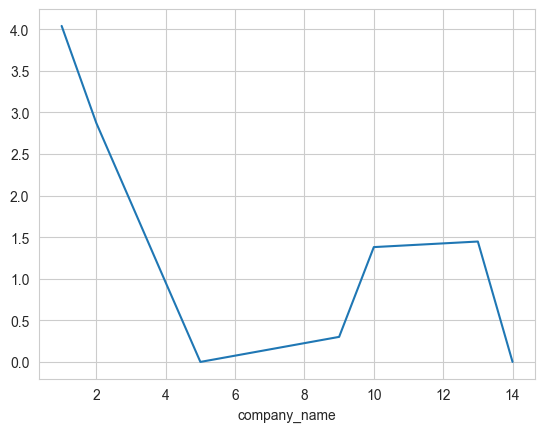

In [42]:
# Create a logarithmic plot of director board membership distribution
# 1. value_counts(): Count how many directors have X number of board positions
# 2. sort_index(): Sort by number of boards (x-axis)
# 3. map(math.log10): Transform counts to a log scale for better visualization
# 4. plot(): Create the visualization
directorship_counts.value_counts().sort_index().map(math.log10).plot()

In [43]:
# Initialize an undirected graph structure using NetworkX
# This will be used to model relationships between directors and companies
# - Nodes can represent directors or companies
# - Edges will represent connections (board memberships)
# - Being undirected means connections have no specific direction
#graph = networkx.Graph()


In [44]:
# Initialize empty lists to store unique directors and companies
#people = []
#companies = []

# Iterate through company-director pairs using zip to process both columns simultaneously
#for company_name, director_name in zip(df_directorships.company_name, df_directorships.director_name):
    # Add an edge to the graph connecting each company to its director
    # This creates a bipartite graph where:
    # - One set of nodes represents companies
    # - Another set represents directors
    # - Edges represent board memberships
   #graph.add_edge(company_name, director_name)

    # Keep track of all directors and companies for later use
   # people.append(director_name)
    #companies.append(company_name)

**Problem 3: Duplicate graph creation logic**
- _Why_: The code creates the same bipartite graph twice in different places, wasting computation and risking inconsistencies
- _Fix_: Create a function to build the graph once and reuse it


In [45]:
# More efficient graph creation
def create_bipartite_network(df):
    """Create a bipartite network from director-company relationships"""
    G = nx.Graph()

    # Add edges directly from DataFrame
    edges = df[['director_name', 'company_name']].values.tolist()
    G.add_edges_from(edges)

    # Use sets for faster membership testing
    people = set(df['director_name'].unique())
    companies = set(df['company_name'].unique())

    return G, people, companies


# Create graph
graph, people, companies = create_bipartite_network(df_directorships)
print(f"Graph created with {len(people)} directors and {len(companies)} companies")

Graph created with 11827 directors and 659 companies


In [46]:

# Extract the largest connected component from graph
# 1. networkx.connected_components(graph) finds all separate groups of connected nodes
# 2. list()[0] takes the first (largest) component
# 3. graph.subgraph() creates a new graph containing only nodes from this component
biggest_connected_graph = graph.subgraph(list(networkx.connected_components(graph))[0])


In [47]:
# Jupyter magic command to measure execution time

# Create a DataFrame with different centrality metrics for each node
#centrality = pd.DataFrame({
    # Eigenvector centrality: measures node importance based on connections to other important nodes
    #'eigen': pd.Series(networkx.eigenvector_centrality(biggest_connected_graph)),

    # Degree centrality: measures the fraction of nodes each node is connected to
   # 'degree': pd.Series(networkx.algorithms.degree_centrality(biggest_connected_graph)),

    # Betweenness centrality: measures how often a node acts as a bridge along shortest paths
    #'betweenness': pd.Series(networkx.betweenness_centrality(biggest_connected_graph))
#})

# Add a boolean column to distinguish between directors and companies
#centrality['is_person'] = centrality.index.map(lambda x: x in people)

**Problem 4: No error handling for centrality calculations**
- _Why_: Network calculations can fail for disconnected graphs or other issues
- _Fix_: Add error handling and logging


In [48]:
%%time
# Jupyter magic command to measure execution time
try:
    # Create a DataFrame with different centrality metrics for each node
    # Calculate centrality measures with error handling
    centrality = pd.DataFrame({
         # Eigenvector centrality: measures node importance based on connections to other important nodes
        'eigen': pd.Series(nx.eigenvector_centrality(biggest_connected_graph, max_iter=1000)),
        # Degree centrality: measures the fraction of nodes each node is connected to
        'degree': pd.Series(nx.degree_centrality(biggest_connected_graph)),
        # Betweenness centrality: measures how often a node acts as a bridge along shortest paths
        'betweenness': pd.Series(nx.betweenness_centrality(biggest_connected_graph))
    })

    print("Centrality calculations successful")
except nx.PowerIterationFailedConvergence:
    print("Warning: Eigenvector centrality failed to converge")
    # Fall back to just degree centrality
    centrality = pd.DataFrame({
        'degree': pd.Series(nx.degree_centrality(biggest_connected_graph))
    })
except Exception as e:
    print(f"Error calculating centralities: {str(e)}")
    raise
# Add a boolean column to distinguish between directors and companies
# Add person indicator
centrality['is_person'] = centrality.index.map(lambda x: x in people)
print("\nCentrality measures calculated for", len(centrality), "nodes")

Centrality calculations successful

Centrality measures calculated for 8204 nodes
CPU times: total: 13min 11s
Wall time: 15min 34s


# Documentation of Centrality Measures
"""
Centrality Measures in Context:

1. Eigenvector Centrality:
   - Measures influence of a node based on connections to other influential nodes
   - High values indicate directors/companies connected to other well-connected entities
   - Important for identifying key players in the corporate network

2. Degree Centrality:
   - Measures direct connections
   - For directors: number of board positions (normalized)
   - For companies: number of directors (normalized)
   - Indicates immediate sphere of influence

3. Betweenness Centrality:
   - Measures how often a node acts as a bridge between others
   - High values indicate directors/companies that could control information flow
   - Crucial for identifying potential dealmakers and intermediaries

This combination of measures helps us identify not just well-connected directors,
but those who might be strategically positioned to facilitate company acquisitions
or mergers through their network positions.
"""

In [49]:
# Create a new DataFrame for directors by:
# 1. Filtering centrality DataFrame to include only directors (is_person == True)
# 2. Merging with demographic and compensation data using director names as index
people_df = centrality[centrality.is_person].merge(compensation_and_demographics,
                                                  left_index=True,
                                                  right_index=True)

# Print the top 5 directors sorted by betweenness centrality
# Shows how important each director is in connecting different parts of the network
print("\nTop 5 Directors by Betweenness Centrality:")
print(people_df.sort_values('betweenness', ascending=False)  # Sort in descending order
      .head()  # Take top 5 records
      [['betweenness', 'age', 'compensation', 'gender']])  # Select specific columns


Top 5 Directors by Betweenness Centrality:
                         betweenness  age  compensation  gender
JAMES H. MORGAN             0.030707   77        221200    male
KERRII B. ANDERSON          0.030179   66        554508  female
PAUL D. DONAHUE             0.028527   68       8250000    male
CHARLES K. STEVENS, III     0.028170   65        495885    male
MATTHEW J. ESPE             0.026364   66        125000    male


In [50]:
# Sort directors by their eigenvector centrality scores in descending order
people_df.sort_values('eigen', ascending=False)

,eigen,degree,betweenness,is_person,age,compensation,gender,log_compensation
PREMA MATHAI-DAVIS,1.024389e-01,0.001585,1.394057e-07,True,74,3208265,female,6.506270
CAROL DECKBAR,1.024389e-01,0.001585,1.394057e-07,True,62,43263,female,4.636127
CYNTHIA HOSTETLER,1.024389e-01,0.001585,1.394057e-07,True,62,3371400,female,6.527810
DOUGLAS SHARP,1.024389e-01,0.001585,1.394057e-07,True,50,0,male,0.000000
"JAMES ""JIM"" LIDDY",1.024389e-01,0.001585,1.394057e-07,True,65,27531,male,4.439838
...,...,...,...,...,...,...,...,...
CHARLES A. ZABATTA,8.400282e-35,0.000122,0.000000e+00,True,82,245000,male,5.389168
ANDREW S. BORODACH,8.342633e-35,0.000122,0.000000e+00,True,56,0,male,0.000000
LAWRENCE A. KOBRIN,8.342633e-35,0.000122,0.000000e+00,True,91,30356,male,4.482259
NANCY J. FLOYD PRUE,8.342633e-35,0.000122,0.000000e+00,True,70,50356,female,4.702060


In [51]:
# Filter the DataFrame to show all information for director Elizabeth Krentzman
people_df[people_df.index == 'ELIZABETH KRENTZMAN']

,eigen,degree,betweenness,is_person,age,compensation,gender,log_compensation
ELIZABETH KRENTZMAN,0.102439,0.001585,1.394057e-07,True,65,3408245,female,6.532531


In [52]:
# Create a RobustScaler object for scaling the data
robust_scaler = sklearn.preprocessing.RobustScaler()

# Scale selected features using RobustScaler
age_and_demographics_scaled = robust_scaler.fit_transform(
    people_df[['age', 'log_compensation', 'degree', 'eigen']]
)

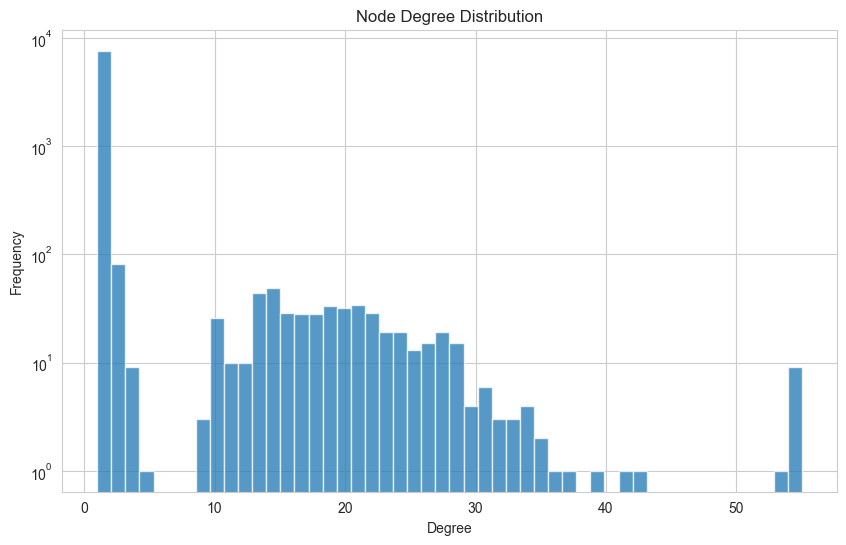

cluster_id
 1    3117
 0     385
 2     109
-1      72
 3      24
 4      19
 7       8
 6       5
 5       3
Name: count, dtype: int64

In [53]:
# Visualize degree distribution
degrees = [d for n, d in biggest_connected_graph.degree()]
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=50, alpha=0.75)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Node Degree Distribution')
plt.yscale('log')
plt.savefig('network_summary.png', dpi=300, bbox_inches='tight')
plt.show()
# Create a DBSCAN clustering model with epsilon (neighbourhood radius) of 0.4
dbscan = sklearn.cluster.DBSCAN(eps=0.4)

# Perform clustering on the scaled features and add cluster assignments to DataFrame
people_df['cluster_id'] = dbscan.fit_predict(age_and_demographics_scaled)

# Count the number of directors in each cluster
people_df.cluster_id.value_counts()

<Axes: xlabel='age', ylabel='log_compensation'>

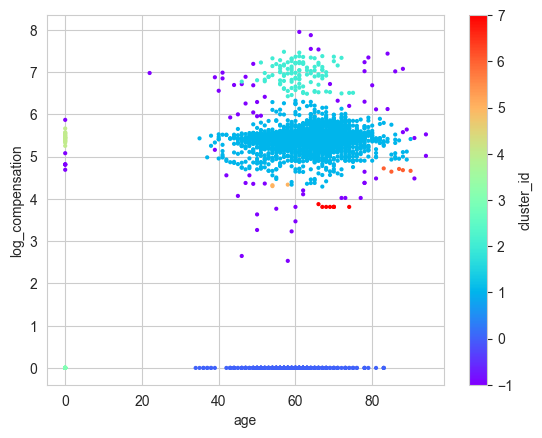

In [54]:
# Create a scatter plot of directors' age vs. compensation, coloured by cluster
people_df.plot.scatter(
    x='age',               # X-axis: director's age
    y='log_compensation',  # Y-axis: log-transformed compensation
    c='cluster_id',        # Colour points by cluster assignment
    cmap="rainbow",        # Use rainbow colormap for different clusters
    s=4                    # Set point size to 4 (small dots)
)

In [55]:
# Get all data for director Elizabeth Krentzman using the index
people_df.loc['ELIZABETH KRENTZMAN']

eigen               0.102439
degree              0.001585
betweenness              0.0
is_person               True
age                       65
compensation         3408245
gender                female
log_compensation    6.532531
cluster_id                 2
Name: ELIZABETH KRENTZMAN, dtype: object

### TASK 4: Complementary dataset

**Complementary Dataset: Crunchbase Enterprise Dataset**

**Dataset Description**
The Crunchbase Enterprise Dataset ([https://www.crunchbase.com/discover/organization.companies](https://www.crunchbase.com/discover/organization.companies)) provides comprehensive information about companies, including their funding history, technology stacks, market focus, and investment relationships.

**How This Dataset Would Enhance Our Analysis**

1. **Financial Context**
   - Add funding history and financial performance metrics to our board network analysis
   - Correlate director connections with company financial success
   - Identify financially attractive acquisition targets

2. **Technology and Market Intelligence**
   - Cross-reference with our existing `software_background` data
   - Map technology stacks similarities between companies
   - Identify complementary technology capabilities for potential acquisitions

3. **Investment Network Analysis**
   - Layer investment relationships over our board network
   - Identify existing financial connections between companies
   - Spot potential acquisition pathways through investment relationships

4. **Industry Segmentation**
   - Add industry classification to the network

### TASK 5: Choose two refinement options
## Selected Refinement Options

### Option A: Improve Data Visualizations for Non-Technical Audience
This is a strong choice because:
1. Our current network analysis produces complex graphs and metrics that need translation for business stakeholders
2. Board network insights are valuable but need clear visual representation
3. Non-technical decision-makers need to understand the implications for acquisition strategy
4. Well-designed visualizations can make complex network relationships immediately apparent

### Option C: Ethics Analysis
This is crucial because:
1. Board network analysis raises important privacy considerations
2. The data involves personal information (compensation, age, relationships)
3. Potential use for acquisition strategy has ethical implications
4. Growing concerns about corporate governance and board diversity

### Value of Selected Options
The combination of (a) and (c) would:
1. Make the analysis more accessible and actionable
2. Address important ethical considerations
3. Create a more complete and responsible analysis
4. Better serve the project's strategic goals



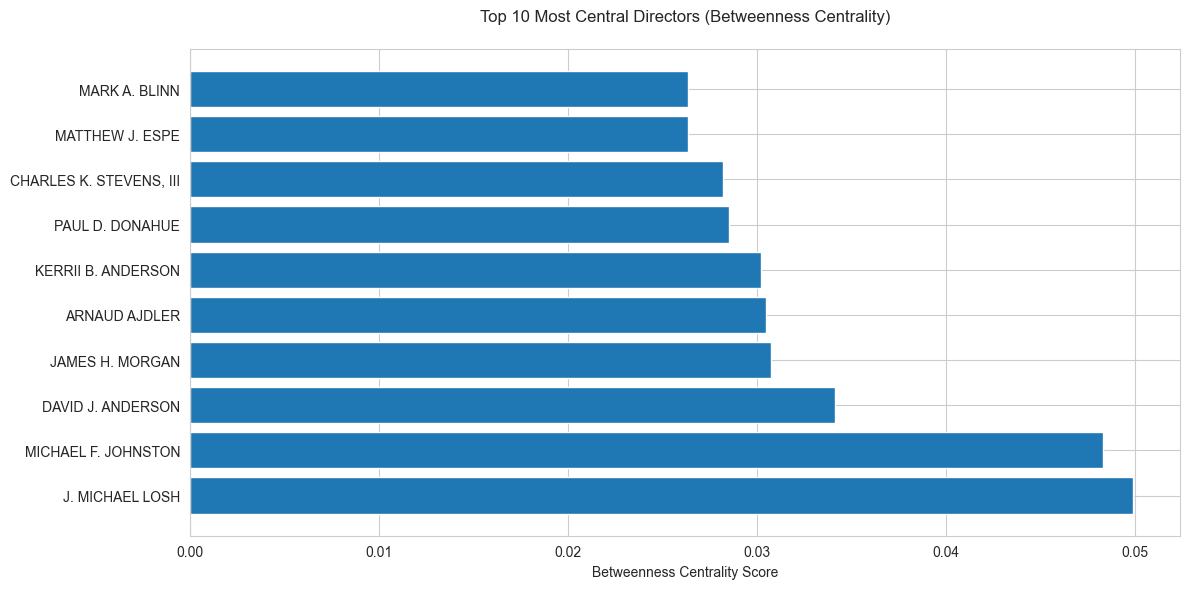

In [56]:
%matplotlib inline

# 1. Top Directors by Betweenness Centrality
plt.figure(figsize=(12, 6))
director_centrality = centrality[centrality['is_person']]
top_directors = director_centrality.nlargest(10, 'betweenness')

plt.barh(range(len(top_directors)), top_directors['betweenness'])
plt.yticks(range(len(top_directors)), top_directors.index)
plt.title('Top 10 Most Central Directors (Betweenness Centrality)', pad=20)
plt.xlabel('Betweenness Centrality Score')
plt.tight_layout()
plt.show()
plt.close()


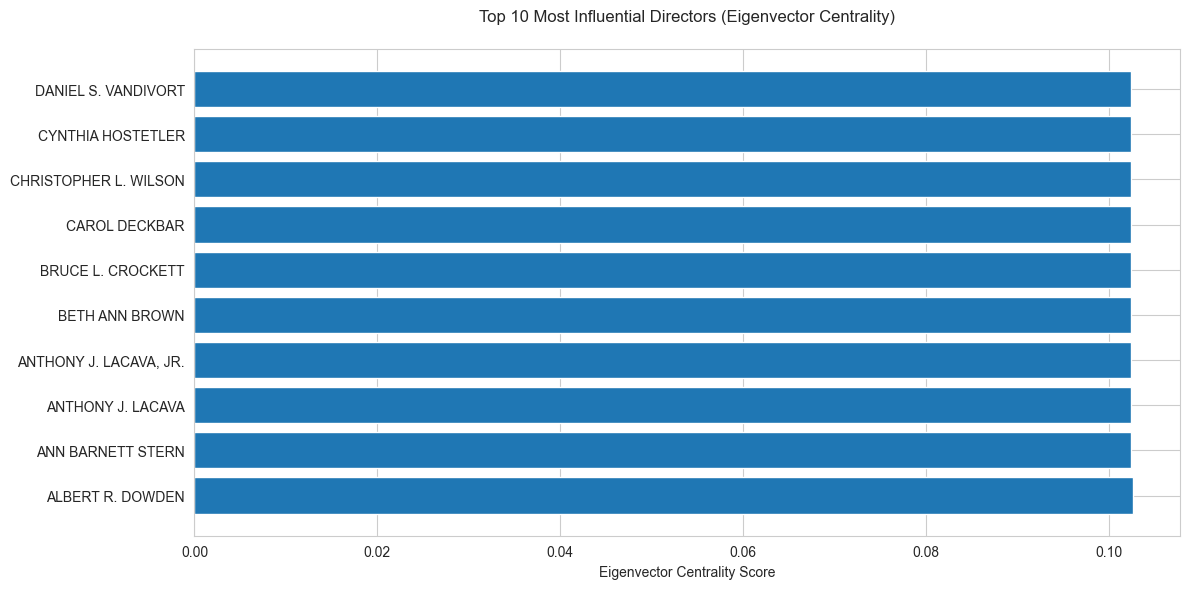

In [57]:

# 2. Top Directors by Eigenvector Centrality
plt.figure(figsize=(12, 6))
top_directors_eigen = director_centrality.nlargest(10, 'eigen')

plt.barh(range(len(top_directors_eigen)), top_directors_eigen['eigen'])
plt.yticks(range(len(top_directors_eigen)), top_directors_eigen.index)
plt.title('Top 10 Most Influential Directors (Eigenvector Centrality)', pad=20)
plt.xlabel('Eigenvector Centrality Score')
plt.tight_layout()
plt.show()
plt.close()


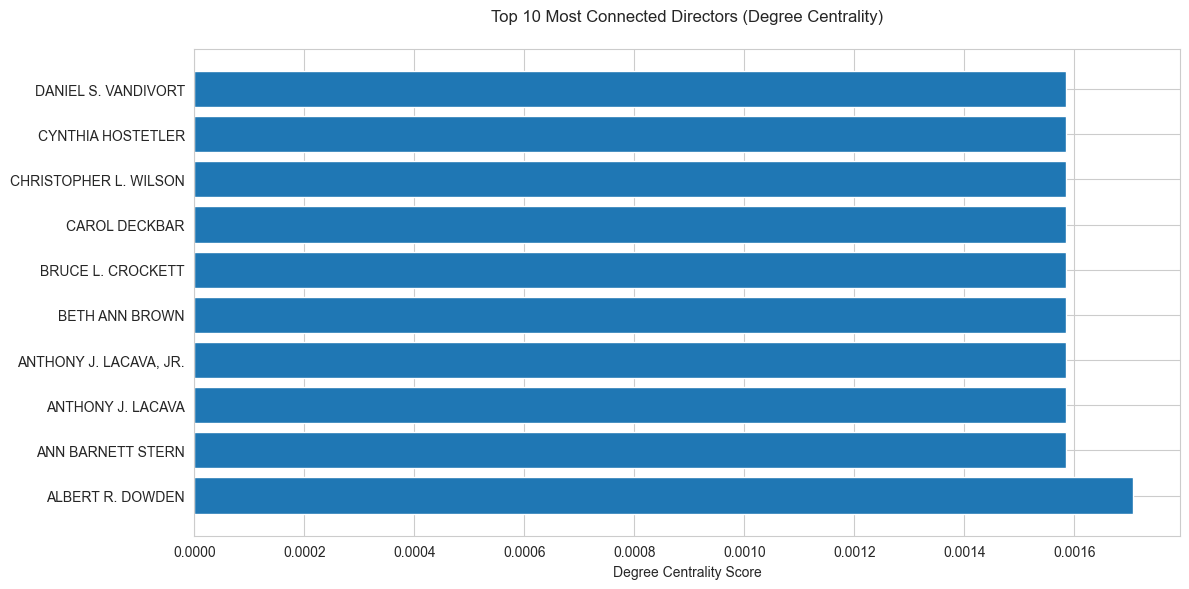

In [58]:

# 3. Top Directors by Degree Centrality
plt.figure(figsize=(12, 6))
top_directors_degree = director_centrality.nlargest(10, 'degree')

plt.barh(range(len(top_directors_degree)), top_directors_degree['degree'])
plt.yticks(range(len(top_directors_degree)), top_directors_degree.index)
plt.title('Top 10 Most Connected Directors (Degree Centrality)', pad=20)
plt.xlabel('Degree Centrality Score')
plt.tight_layout()
plt.show()
plt.close()


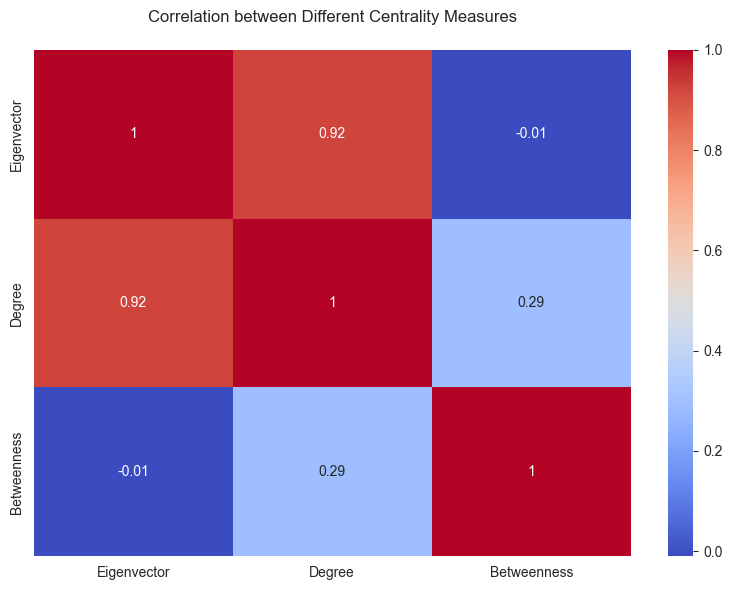

In [59]:

# 4. Correlation Heatmap between Centrality Measures
plt.figure(figsize=(8, 6))
director_correlations = director_centrality[['eigen', 'degree', 'betweenness']].corr()
sns.heatmap(director_correlations, annot=True, cmap='coolwarm',
            xticklabels=['Eigenvector', 'Degree', 'Betweenness'],
            yticklabels=['Eigenvector', 'Degree', 'Betweenness'])
plt.title('Correlation between Different Centrality Measures', pad=20)
plt.tight_layout()
plt.show()
plt.close()


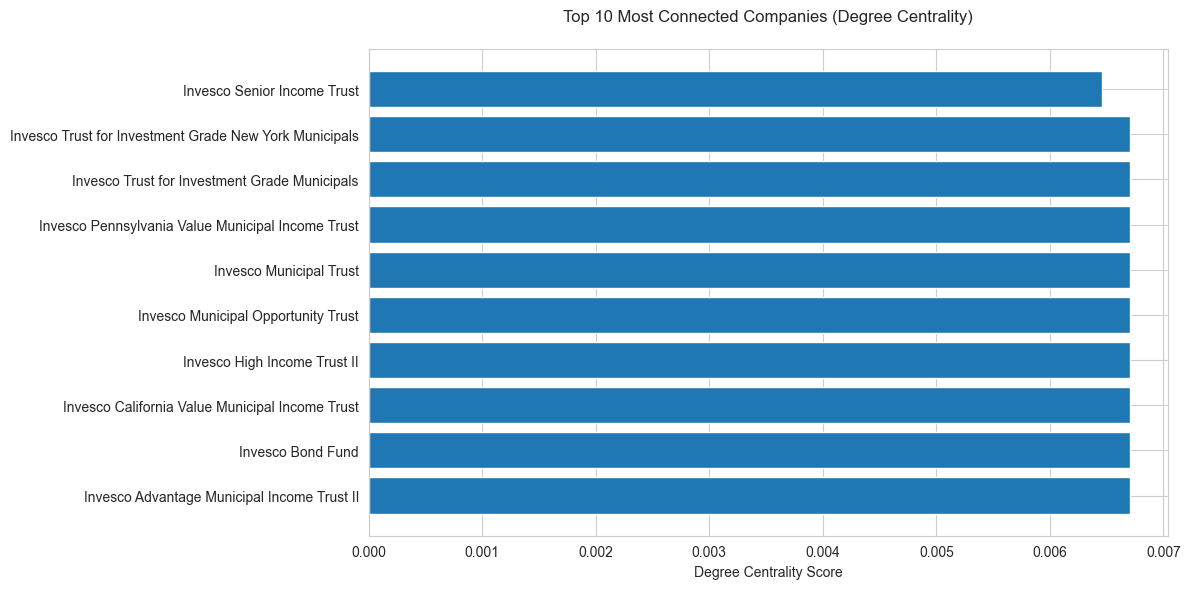

In [60]:

# 5. Top Companies by Degree Centrality
plt.figure(figsize=(12, 6))
company_centrality = centrality[~centrality['is_person']]
top_companies = company_centrality.nlargest(10, 'degree')

plt.barh(range(len(top_companies)), top_companies['degree'])
plt.yticks(range(len(top_companies)), top_companies.index)
plt.title('Top 10 Most Connected Companies (Degree Centrality)', pad=20)
plt.xlabel('Degree Centrality Score')
plt.tight_layout()
plt.show()
plt.close()

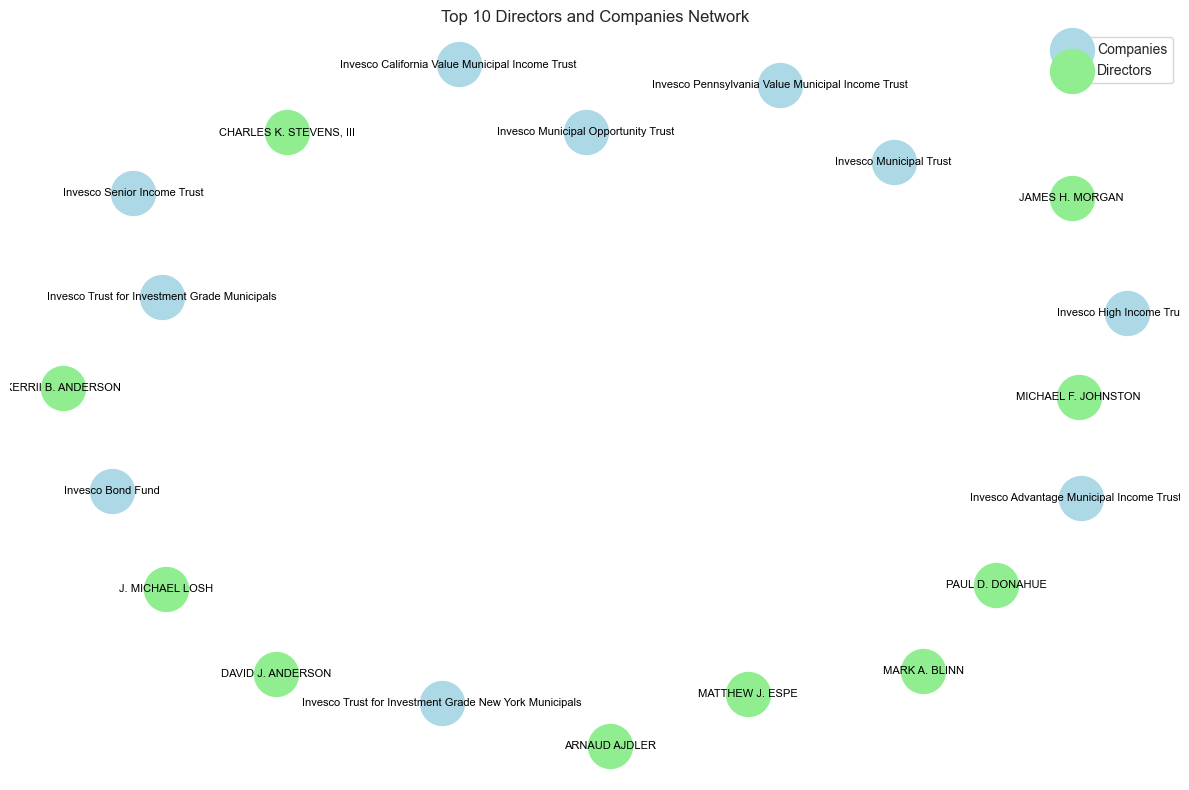

In [61]:
# First get top 10 directors by centrality
director_centrality = centrality[centrality['is_person']]
top_10_directors = director_centrality.nlargest(10, 'betweenness').index.tolist()

# Get top 10 companies by degree centrality
company_centrality = centrality[~centrality['is_person']]
top_10_companies = company_centrality.nlargest(10, 'degree').index.tolist()

# Create subgraph with only top directors and companies
top_nodes = top_10_directors + top_10_companies
subgraph = biggest_connected_graph.subgraph(top_nodes)

# Visualize network
plt.figure(figsize=(12, 8))

# Create spring layout for graph positioning
pos = nx.spring_layout(subgraph, k=1, iterations=50)

# Draw the network with different colors for companies and directors
nx.draw_networkx_nodes(subgraph, pos,
                       nodelist=[n for n in subgraph.nodes() if n in top_10_companies],
                       node_color='lightblue',
                       node_size=1000,
                       label='Companies')
nx.draw_networkx_nodes(subgraph, pos,
                       nodelist=[n for n in subgraph.nodes() if n in top_10_directors],
                       node_color='lightgreen',
                       node_size=1000,
                       label='Directors')
nx.draw_networkx_edges(subgraph, pos, alpha=0.5, width=2)

# Add labels to nodes
nx.draw_networkx_labels(subgraph, pos, font_size=8)

plt.title('Top 10 Directors and Companies Network')
plt.legend()
plt.axis('off')
plt.tight_layout()
plt.show()

C:\Users\pc\AppData\Local\Temp\ipykernel_32408\2265908791.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


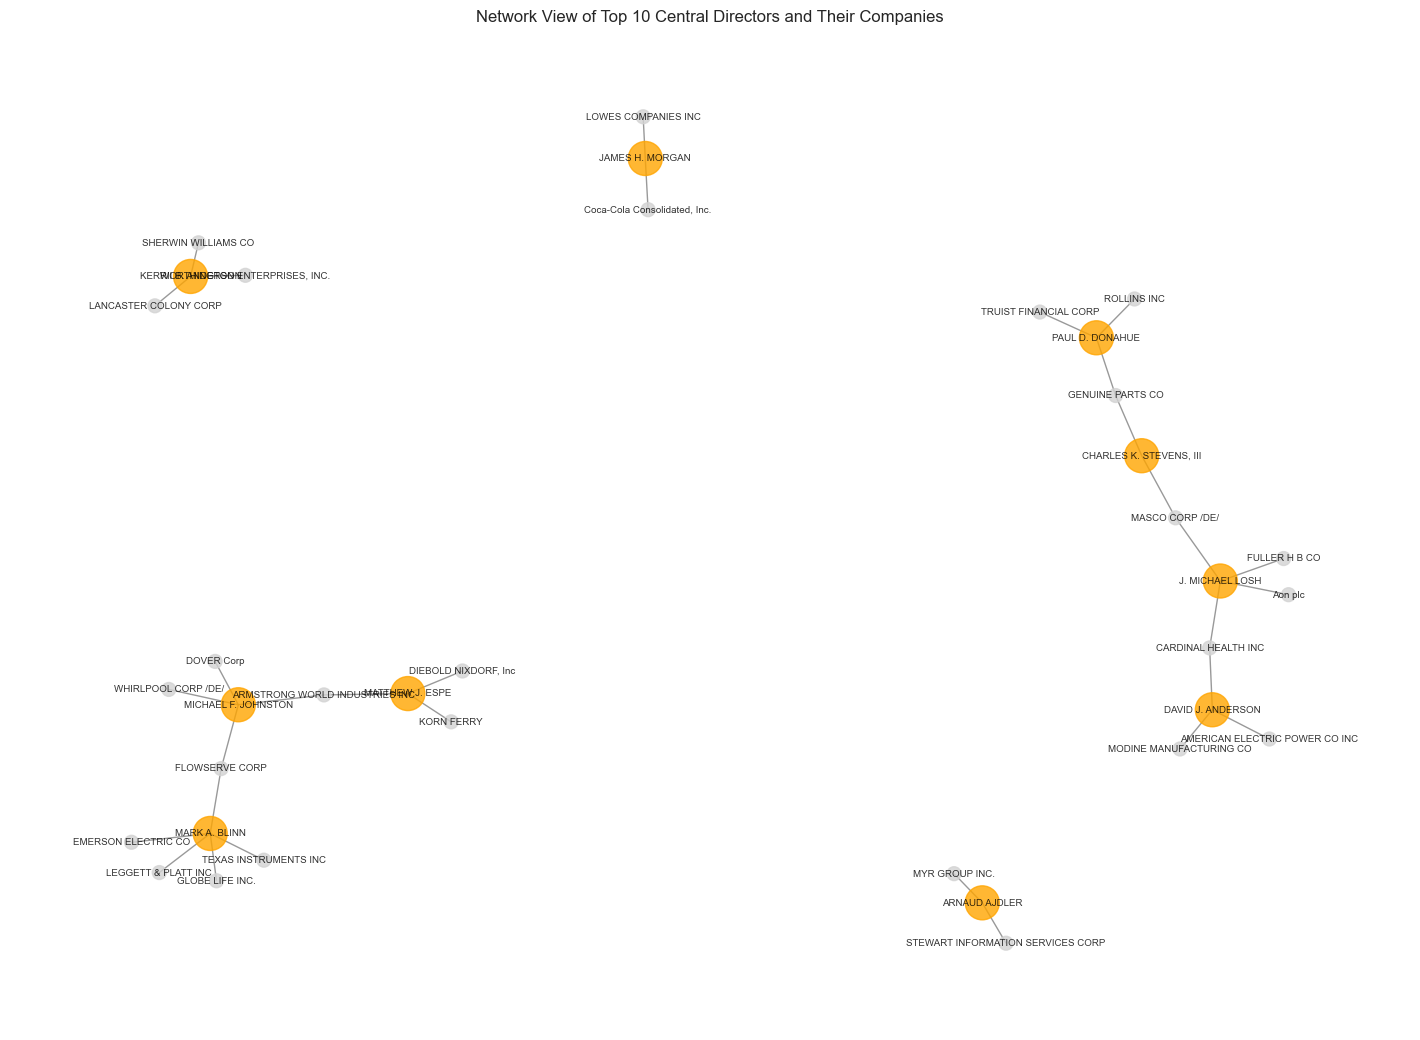

In [62]:
# Get top 10 directors by centrality
director_centrality = centrality[centrality['is_person']]
top_directors = director_centrality.nlargest(10, 'betweenness').index.tolist()

# Create list of nodes including top directors and their connected companies
sub_nodes = top_directors.copy()
for d in top_directors:
    sub_nodes.extend(biggest_connected_graph.neighbors(d))

# Create subgraph
G_sub = biggest_connected_graph.subgraph(sub_nodes)
pos = nx.spring_layout(G_sub, seed=42)

# Style nodes
node_colors = []
node_sizes = []

for node in G_sub.nodes():
    if node in top_directors:
        node_colors.append("orange")
        node_sizes.append(600)
    elif node in people:
        node_colors.append("lightblue")
        node_sizes.append(200)
    else:
        node_colors.append("lightgray")
        node_sizes.append(100)

# Create visualization
plt.figure(figsize=(14, 10))
nx.draw(G_sub, pos,
        node_color=node_colors,
        node_size=node_sizes,
        with_labels=True,
        font_size=7,
        edge_color="gray",
        alpha=0.8)
plt.title("Network View of Top 10 Central Directors and Their Companies")
plt.tight_layout()
plt.show()

C:\Users\pc\AppData\Local\Temp\ipykernel_32408\488054814.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=director_counts.values, y=director_counts.index, palette="Greens_r")


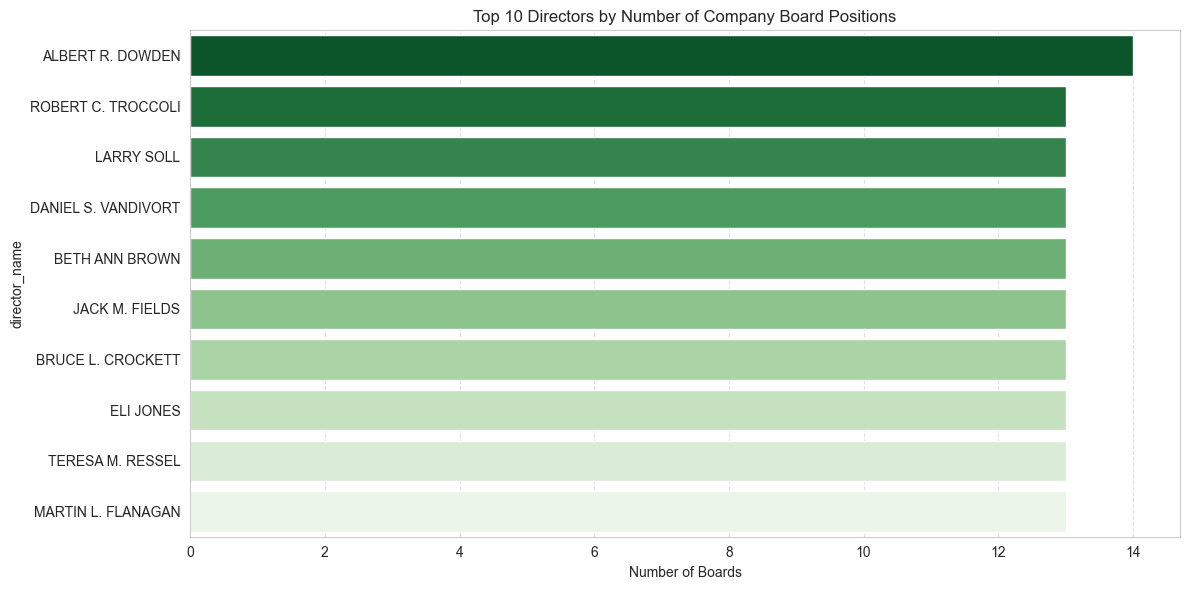

In [63]:
import seaborn as sns

# Director Board Count Plot
# Count how many companies each director is part of
director_counts = df_directorships["director_name"].value_counts().head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=director_counts.values, y=director_counts.index, palette="Greens_r")
plt.xlabel("Number of Boards")
plt.title("Top 10 Directors by Number of Company Board Positions")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

## Task 5c: Ethics Commentary

### What This Project Does

This project uses publicly filed data (DEF 14A forms) to build a social network of company directors. It identifies individuals with high influence based on their board connections, compensation, and potential U.S. affiliations, to support a targeted acquisition strategy by a venture capital fund.

---

### What Might Be Ethically Concerning

Even though the data is public, this kind of analysis repurposes it for influence profiling, which raises ethical concerns:

- **Targeting Individuals**: We are identifying people as strategic assets, not based on consent, but based on network influence.
- **Profiling Without Transparency**: Directors do not know they’re being analyzed, scored, and ranked.
- **Function Creep**: Data filed for corporate transparency is now used for acquisition pressure and strategic networking.

---

### Fairness, Bias, and Privacy Risks

There is risk of bias and inequity in this model:

- **Age/Gender Bias**: Older, male, highly-paid directors may dominate influence rankings.
- **Network Bias**: Those from elite institutions or firms will be overrepresented.
- **Privacy**: While the data is technically public, aggregating and ranking people turns it into a quasi-surveillance tool.

---

### Reflections and Responsible Use

This analysis can be valuable for investors — but it must be handled carefully.

Using it to guide **human interaction or due diligence** is reasonable.
Using it to apply **pressure or manipulate networks** without transparency could erode trust and cross ethical lines.

A responsible use would be:
- Sharing insights **internally**, not publicly
- Ensuring decisions include **human judgment**
- Avoiding use of protected attributes like gender or age
